# We will be using Dask and not pandas as using pandas to load the csv file causes the colab runtime to crash

If running the code for first time, please restart the kernel after running the cell below

In [1]:
## If you are running the code for the first itme, Restart the kernel after running this cell

!pip install dask[dataframe]
!pip install dask_ml
!pip install xgboost
!pip install dask_xgboost


import dask
import xgboost
import dask_xgboost
import dask_ml
from dask_ml.model_selection import train_test_split
import pandas as pd
import dask.dataframe as dd
import numpy as np

# Downloading and processing the data

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz

--2020-10-30 22:27:56--  https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2816407858 (2.6G) [application/x-httpd-php]
Saving to: ‘HIGGS.csv.gz’

HIGGS.csv.gz        100%[===================>]   2.62G  57.2MB/s    in 50s     

2020-10-30 22:28:46 (54.2 MB/s) - ‘HIGGS.csv.gz’ saved [2816407858/2816407858]



In [3]:
 !gzip -d HIGGS.csv.gz

In [4]:
df = dd.read_csv("./HIGGS.csv", header=None, names=[str(x) for x in range(29)])

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,1.374992,-0.653674,0.930349,1.107436,1.138904,-1.578198,-1.046985,0.000000,0.657930,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,-0.213642,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,1.540659,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,-0.676016,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,1.020974,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487


In [6]:
data = df.iloc[:,1:]
data.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,1.374992,-0.653674,0.930349,1.107436,1.138904,-1.578198,-1.046985,0.000000,0.657930,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,-0.213642,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,1.540659,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,-0.676016,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,1.020974,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487


In [7]:
labels = df.iloc[:,0]
labels.head()

0    1.0
1    1.0
2    1.0
3    0.0
4    1.0
Name: 0, dtype: float64

## Finding correlation between the features of the data

### This takes a lot of time to load

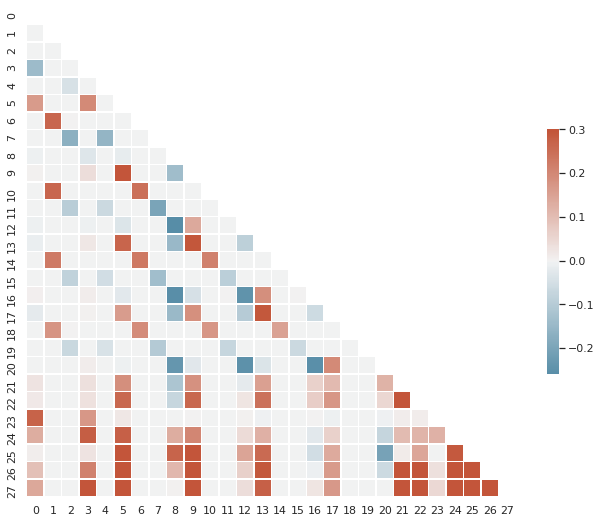

In [8]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_theme(style="white")


# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Drop columns 25, 26, 27 for fast and efficient training (as they show very high correlation)

In [9]:
data = data.drop(['25','26','27'], axis=1)

In [10]:
data.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,28
0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,1.374992,-0.653674,0.930349,1.107436,1.138904,-1.578198,-1.046985,0.000000,0.657930,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.876678
1,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,-0.213642,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.798343
2,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,1.540659,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.780118
3,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,-0.676016,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.957904
4,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,1.020974,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.808487


## Data split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.0046)
X_misc, X_train, y_misc, y_train = train_test_split(data, labels, test_size=0.2)

In [12]:
from dask.distributed import Client

client = Client(n_workers=4, threads_per_worker=1)
client

Client Scheduler: tcp://127.0.0.1:34959 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 13.65 GB


# Training phase

In [13]:
params = {'objective': 'binary:logistic',
          'max_depth': 12, 'eta': 0.01, 'subsample': 0.5,
          'min_child_weight': 0.5}

X_test_c = X_test
y_test_c = y_test

X_test = X_test.compute()
y_test = y_test.compute()


evals_result = {}
bst = dask_xgboost.train(client, params, X_train, y_train, num_boost_round=10, eval_set = [(X_test, y_test)], evals_result=evals_result)

/usr/local/lib/python3.6/dist-packages/distributed/worker.py:3382: UserWarning: Large object of size 11.77 MB detected in task graph: 
  {'dmatrix_kwargs': {}, 'num_boost_round': 10, 'eva ... ype: float64)]}
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


In [14]:
bst

## Model analysis

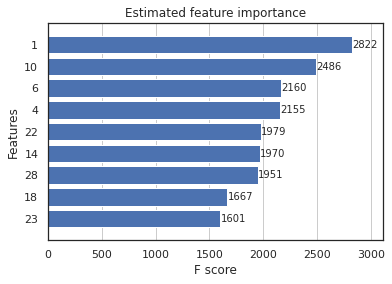

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

ax = xgboost.plot_importance(bst, height=0.8, max_num_features=9)
ax.grid(False, axis="y")
ax.set_title('Estimated feature importance')
plt.show()

In [16]:
y_hat = dask_xgboost.predict(client, bst, X_test_c).persist()
y_hat

dask.array<values, shape=(nan,), dtype=float32, chunksize=(nan,), chunktype=numpy.ndarray>

In [17]:
y_hat = dask.compute(y_hat)
y_hat

(array([0.5131909 , 0.4819766 , 0.50225693, ..., 0.5052703 , 0.4884563 ,
        0.49300104], dtype=float32),)

In [18]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_hat[0])

# Model evaluation phase

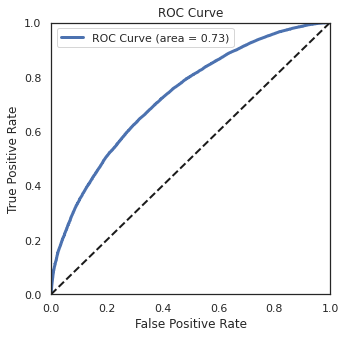

In [19]:
from sklearn.metrics import auc

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, lw=3,
        label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend();
plt.show()

In [20]:
len(evals_result["validation_0"]['error'])

10

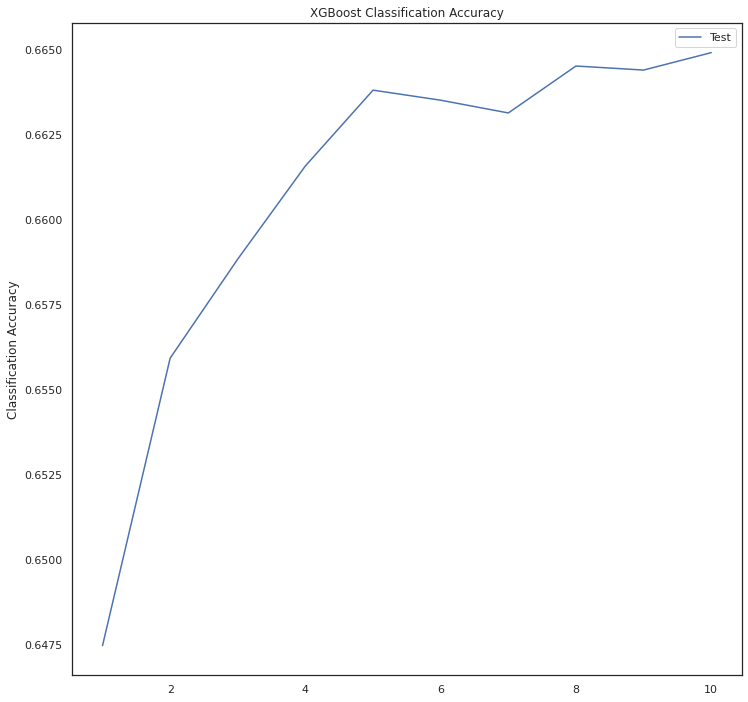

In [21]:
results = evals_result
epochs = len(results['validation_0']['error'])
x_axis = range(1, epochs+1)
accuracies = [1-x for x in results['validation_0']['error']]
    
    
# plot classification error
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(x_axis, accuracies, label='Test')
ax.legend()
    
plt.ylabel('Classification Accuracy')
plt.title('XGBoost Classification Accuracy')
plt.show()

In [22]:
y_hat

(array([0.5131909 , 0.4819766 , 0.50225693, ..., 0.5052703 , 0.4884563 ,
        0.49300104], dtype=float32),)

In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [25]:
y_test, y_hat = dask.compute(y_test, y_hat)
acc = accuracy_score(y_test, y_hat[0].round())
print(f"Test accuracy = {acc}")

Test accuracy = 0.6649181620982055


In [27]:
pd.DataFrame(confusion_matrix(y_test, y_hat[0].round()))

,0,1
0,14586,9258
1,7734,19132
